In [1]:
#PODSUMOWANIE wszystkich 4 modeli

In [13]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import shap
import ipywidgets as widgets
from IPython.display import display


def save_model(model, path):
    with open(path, 'wb') as f:
        pickle.dump(model, f)

def load_model(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def evaluate_models(models_paths, X_test, y_test):
    results = []
    plt.figure(figsize=(10, 8))
    
    for path in models_paths:
        name = path.split("/")[-1].split(".")[0]
        model = load_model(path)
        y_proba = model.predict_proba(X_test)[:, 1]
        """
        
        thresholds = np.linspace(0.1, 0.9, 81)
        for t in thresholds:
            y_pred = (y_proba >= t).astype(int)
            rec = recall_score(y_test, y_pred)
            if rec > best_recall:
                best_recall = rec
                best_threshold = t
        """
        best_threshold, best_recall = 0.5, 0
        y_pred_best = (y_proba >= best_threshold).astype(int)

        precision = precision_score(y_test, y_pred_best)
        recall = recall_score(y_test, y_pred_best)
        f1 = f1_score(y_test, y_pred_best)
        auc = roc_auc_score(y_test, y_proba)
        cm = confusion_matrix(y_test, y_pred_best)

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

        results.append({
            'model': name,
            'threshold': best_threshold,
            'recall': recall,
            'precision': precision,
            'f1': f1,
            'auc': auc,
            'confusion_matrix': cm,
            'model_obj': model,
            'y_proba': y_proba
        })

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid()
    plt.show()

    df_results = pd.DataFrame([{k: v for k, v in r.items() if k not in ['model_obj', 'y_proba', 'confusion_matrix']} for r in results])
    display(df_results.sort_values('recall', ascending=False))

    for res in results:
        print("\n=================", res['model'], "=================")
        print(f"Threshold: {res['threshold']:.2f}, Recall: {res['recall']:.3f}, Precision: {res['precision']:.3f}, F1: {res['f1']:.3f}, AUC: {res['auc']:.3f}")
        print("Confusion matrix:")
        print(res['confusion_matrix'])

        try:
            explainer = shap.TreeExplainer(res['model_obj'])
            shap_values = explainer.shap_values(X_test)
            shap.summary_plot(shap_values, X_test, show=False)
            plt.title(f"SHAP Summary: {res['model']}")
            plt.show()
        except Exception as e:
            print(f"[!] SHAP not supported for {res['model']}:", e)

    def interactive_threshold(model_result):
        def update(thresh):
            y_pred = (model_result['y_proba'] >= thresh).astype(int)
            cm = confusion_matrix(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            print(f"\nThreshold: {thresh:.2f}")
            print("Confusion matrix:")
            print(cm)
            print(f"Recall: {recall:.3f}, Precision: {precision:.3f}, F1: {f1:.3f}")

        return widgets.interact(update, thresh=widgets.FloatSlider(min=0.1, max=0.9, step=0.01, value=model_result['threshold']))

    print("\n========= Interaktywny próg dla najlepszego modelu =========")
    best_model = max(results, key=lambda x: x['recall'])
    print(f"Najlepszy model to: {best_model['model']}")
    interactive_threshold(best_model)
    print(best_model)


c:\Users\66891\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [00:49:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


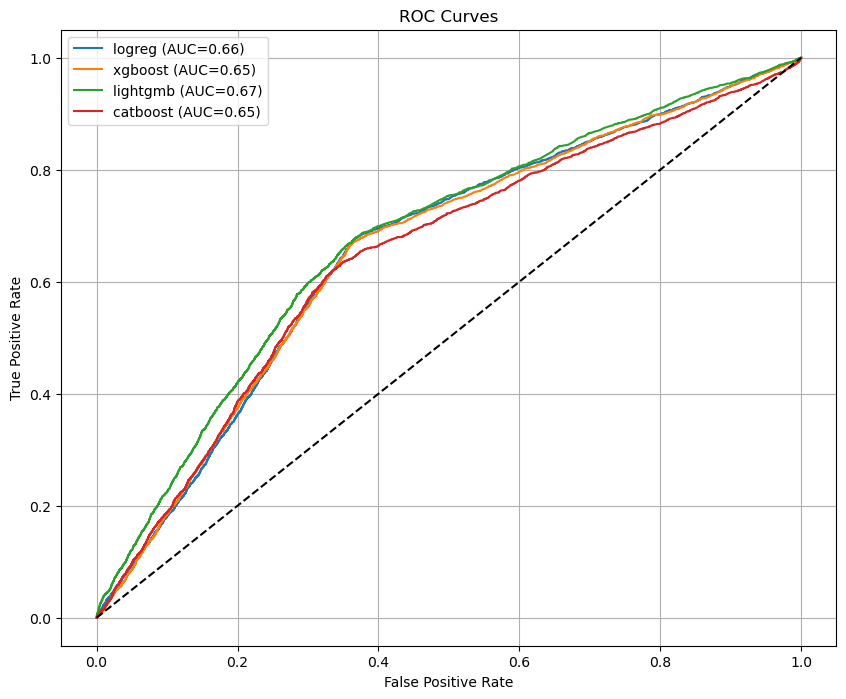

,model,threshold,recall,precision,f1,auc
0,logreg,0.5,0.679401,0.070659,0.128005,0.656157
2,lightgmb,0.5,0.664435,0.071778,0.129560,0.674692
1,xgboost,0.5,0.631745,0.070589,0.126989,0.654782
3,catboost,0.5,0.534856,0.072376,0.127500,0.646510



================= logreg =================
Threshold: 0.50, Recall: 0.679, Precision: 0.071, F1: 0.128, AUC: 0.656
Confusion matrix:
[[38888 22688]
 [  814  1725]]
[!] SHAP not supported for logreg: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>

================= xgboost =================
Threshold: 0.50, Recall: 0.632, Precision: 0.071, F1: 0.127, AUC: 0.655
Confusion matrix:
[[40457 21119]
 [  935  1604]]


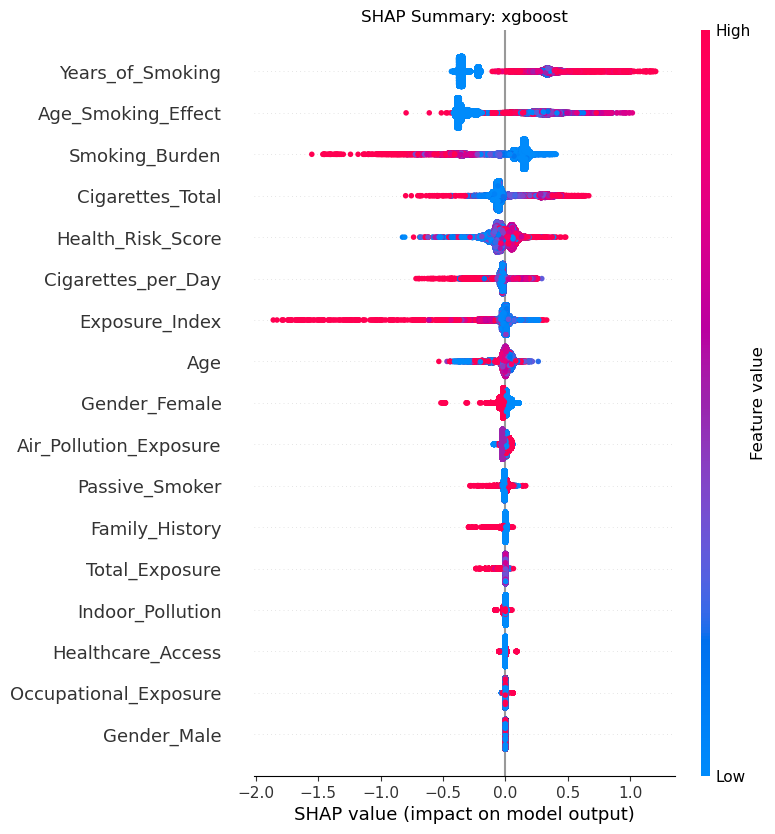


================= lightgmb =================
Threshold: 0.50, Recall: 0.664, Precision: 0.072, F1: 0.130, AUC: 0.675
Confusion matrix:
[[39760 21816]
 [  852  1687]]


c:\Users\66891\anaconda3\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


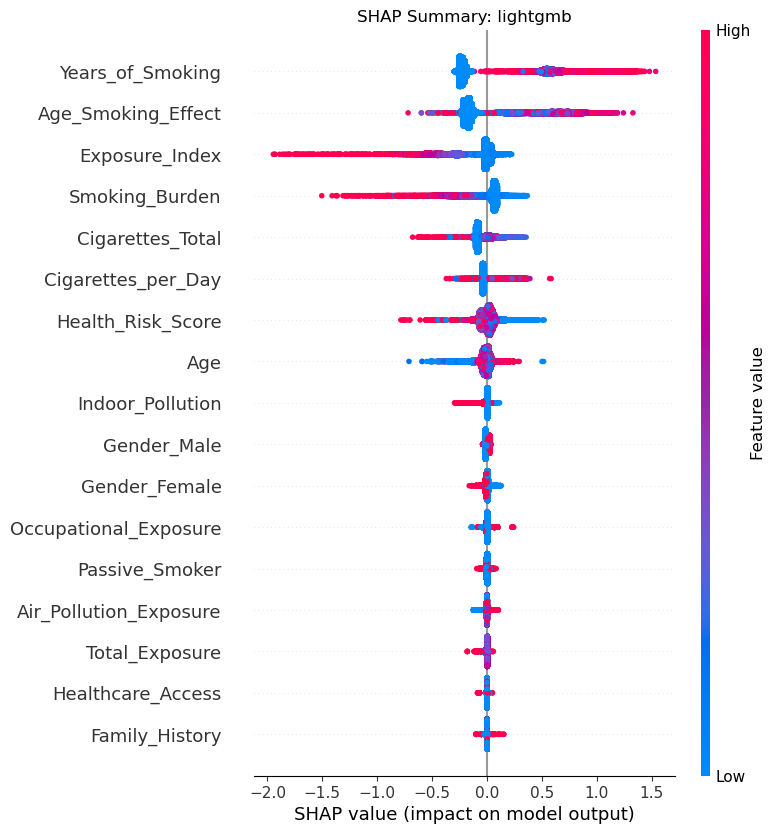


================= catboost =================
Threshold: 0.50, Recall: 0.535, Precision: 0.072, F1: 0.127, AUC: 0.647
Confusion matrix:
[[44171 17405]
 [ 1181  1358]]


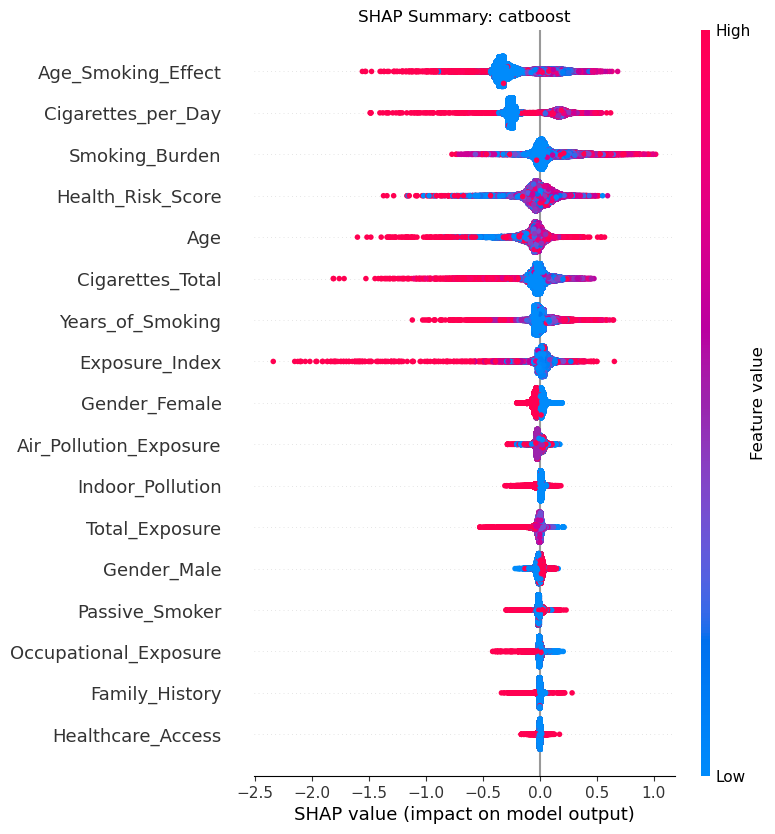


========= Interaktywny próg dla najlepszego modelu =========
Najlepszy model to: logreg


interactive(children=(FloatSlider(value=0.5, description='thresh', max=0.9, min=0.1, step=0.01), Output()), _d…

{'model': 'logreg', 'threshold': 0.5, 'recall': 0.6794013391098858, 'precision': 0.07065907508294761, 'f1': 0.1280053428317008, 'auc': 0.6561570608037801, 'confusion_matrix': array([[38888, 22688],
       [  814,  1725]], dtype=int64), 'model_obj': LogisticRegression(C=0.01, class_weight='balanced', l1_ratio=0.0, max_iter=500,
                   random_state=42, solver='saga'), 'y_proba': array([0.53065063, 0.65048973, 0.49795111, ..., 0.59580889, 0.49827306,
       0.62158658])}


In [14]:
df = pd.read_csv('learning_set.csv')
df.head()

# Zakładamy, że kolumna celu nazywa się:
target_column = 'Lung_Cancer_Diagnosis'

X = df.drop(columns=[target_column])
y = df[target_column]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,        # zachowujemy proporcje klas!
    random_state=42
)

evaluate_models(
    models_paths=[
        "models/logreg.pkl",
        "models/xgboost.pkl",
        "models/lightgmb.pkl",
        "models/catboost.pkl"
    ],
    X_test=X_test,
    y_test=y_test
)